In [1]:
import gzip
import glob
import pandas as pd
import datetime
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from statsmodels.regression.mixed_linear_model import MixedLM
from scipy import optimize
from cvxopt import solvers, matrix
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Import Data

Sorry, professor. Due to the limited time, I only run the data for one year and I believe the rest years should be able to be applied to the same algorithm. And I think the contents are way more difficult to our level knowledge base, and one semester is quite limited to master all the knowledge, I do negatiated with some of my schoolmates and industry people to get some ideas. But I do learn a lot of knowledges, thank you very much!

In [2]:
x = glob.glob('apt-2017/*.gz')
data2017 = {}
for i in range(len(x)):
    tmp = pd.read_csv(x[i],sep='|')
    tmp = tmp.fillna(0)
    data2017[x[i][13:23]] = tmp

In [3]:
dates = list(data2017.keys())

In [4]:
style_factors = ["BETA","MOMENTUM","SIZE","VOL"]
alpha_factors = ["td","tir"]

Problem1

1.a

In [5]:
f_OLS_matrix = pd.DataFrame(index=dates,columns=style_factors+alpha_factors)
residual2_OLS = pd.DataFrame()
for date in dates:
    df1 = data2017[date]
    X = df1[style_factors+alpha_factors]
    R = df1["R"]
    X_inverse = np.linalg.inv(X.T.dot(X))
    f_OLS = X_inverse.dot(X.T).dot(R)
    f_OLS.reshape(1,-1)
    f_OLS_matrix.loc[date] = f_OLS
    R_hat = np.dot(X,f_OLS.T)
    residual2 = np.power(R - R_hat,2)
    residual2.name = date
    residual2.index = df1.ID
    residual2_OLS = pd.concat([residual2_OLS,residual2],axis=1,sort=False)

In [6]:
sigma2_hat = residual2_OLS.mean(axis=1)
f_WLS_matrix = pd.DataFrame(index=dates,columns=style_factors+alpha_factors)
for date in dates:
    df1 = data2017[date]
    X = df1[style_factors+alpha_factors]
    R = df1["R"]
    W = np.diag(1/sigma2_hat[X.index])
    f_WLS = np.linalg.inv(X.T.dot(W).dot(X)).dot(X.T).dot(W).dot(R)
    f_WLS.reshape(1,-1)
    f_WLS_matrix.loc[date] = f_WLS

1.b

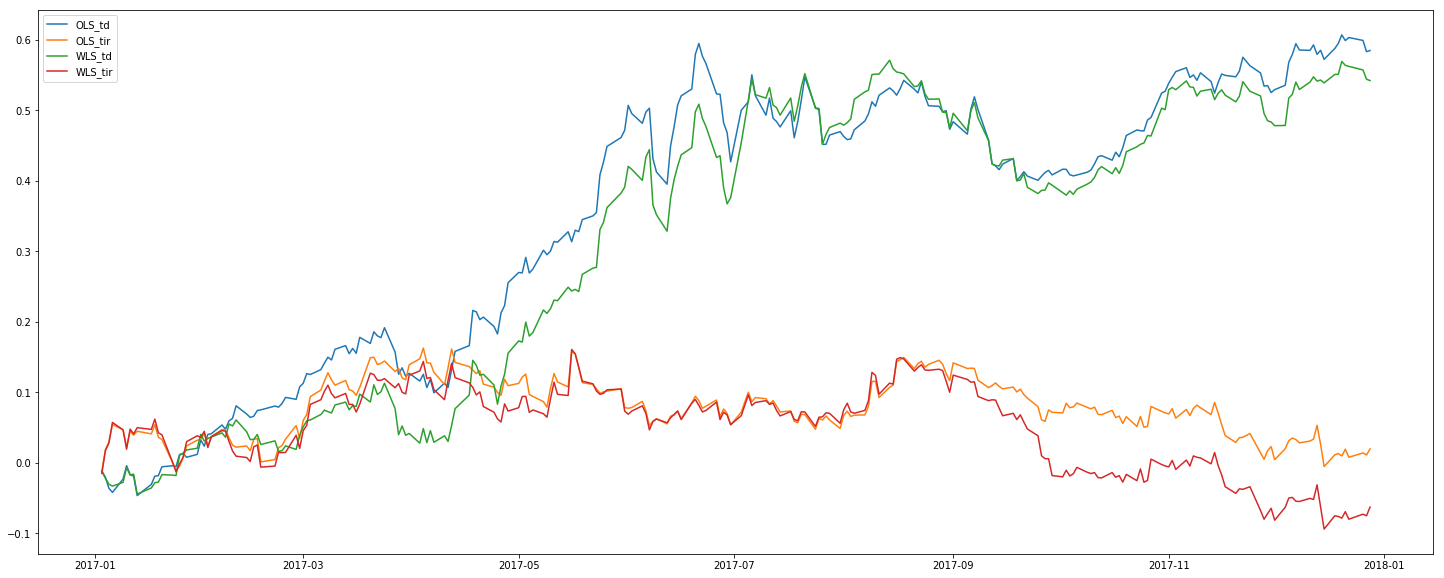

In [7]:
# Plot the cummulative-sum time series of alpha factors elements
f_OLS_matrix.index = pd.to_datetime(f_OLS_matrix.index)
f_WLS_matrix.index = pd.to_datetime(f_WLS_matrix.index)
f_OLS_matrix = f_OLS_matrix.sort_index()
f_WLS_matrix = f_WLS_matrix.sort_index()
cumsum_OLS = f_OLS_matrix[alpha_factors].cumsum()
cumsum_WLS = f_WLS_matrix[alpha_factors].cumsum()
plt.figure(figsize=(25,10))
plt.plot(cumsum_OLS)
plt.plot(cumsum_WLS)
plt.legend(["OLS_td","OLS_tir","WLS_td","WLS_tir"])

1.c

In [8]:
st = np.arange(250)
st = st.reshape(-1,1)
st[0] = 1
mean_OLS = pd.DataFrame(cumsum_OLS.values/st,index = cumsum_OLS.index,columns = cumsum_OLS.columns)
mean_WLS = pd.DataFrame(cumsum_WLS.values/st,index = cumsum_WLS.index,columns = cumsum_WLS.columns)

In [9]:
mean_OLS.head()

,td,tir
2017-01-03,-0.0112944,-0.0109864
2017-01-04,-0.0203634,0.0186414
2017-01-05,-0.0180443,0.0149009
2017-01-06,-0.0139316,0.0181171
2017-01-09,-0.0057156,0.0117426


In [10]:
mean_WLS.head()

,td,tir
2017-01-03,-0.0121472,-0.0150266
2017-01-04,-0.0217335,0.0172913
2017-01-05,-0.0150971,0.0141513
2017-01-06,-0.01096,0.0191309
2017-01-09,-0.00691266,0.0117172


In [11]:
def pinv(A):#pseudoinverse
    [U, S, V] = np.linalg.svd(A)#SVD
    T = S.copy()
    T[np.where(T != 0)] = 1. / S[np.where(S != 0)]
    return np.dot(np.dot(V.T, np.diag(T)), U.T)

Problem2

2.a

In [12]:
def h(kappa,D,X,F,miu):
    D2 = D.copy()
    D2[np.where(D2!=0)] = 1./np.sqrt(D2[np.where(D2!=0)])
    f = (1/kappa)*D2*pinv(np.dot(X.T,D2))
    s = np.dot(np.linalg.inv(F+pinv(np.dot(np.dot(X.T,np.linalg.inv(D)),X))),miu)
    return np.dot(f,s)

In [13]:
F = f_OLS_matrix.expanding(1).corr()
amount = pd.Series()
H_matrix = pd.DataFrame()
PNL_matrix = pd.DataFrame()
cost_matrix = pd.DataFrame()

In [14]:
for date in dates:
    #print("Calculating %s" % date)
    df = data2017[date]
    X = df[style_factors + alpha_factors]

    alpha = X.td + X.tir

    Fi = F.loc[date, :, :]
    D = np.diag(sigma2_hat[X.index])
    #D = np.diag(df['RESVOL']**2)
    #print(D.shape)
    #print(F_i.shape)
    Sigma = np.dot(np.dot(X, Fi), X.T) + D
    Sigma = pd.DataFrame(Sigma, index=X.index, columns=X.index)
    heq = df["USDCAP"]

    if len(Sigma.dropna().index) > 0:
        Sigma = Sigma.fillna(0)
        R = df["R"]

        hk = pd.Series(np.dot(pinv(Sigma), alpha), index=X.index, name=date)
        #hs = h(1,D,X,F_i,R)
        
        H_matrix = pd.concat([H_matrix, hk], axis=1)

        cost = np.power(hk, 2) / (10 ** 13)#ADVP:8,10bps:3,0.01:2
        # print(cost)
        pnl = pd.DataFrame(hk * R, columns=[date])
        PNL_matrix = pd.concat([PNL_matrix, pnl], axis=1)
        cost_matrix = pd.concat([cost_matrix, cost], axis=1)

2.b

In [15]:
kappa = H_matrix.abs().sum(axis=0).mean() / 500
H_matrix = H_matrix / kappa

2.c 2.d

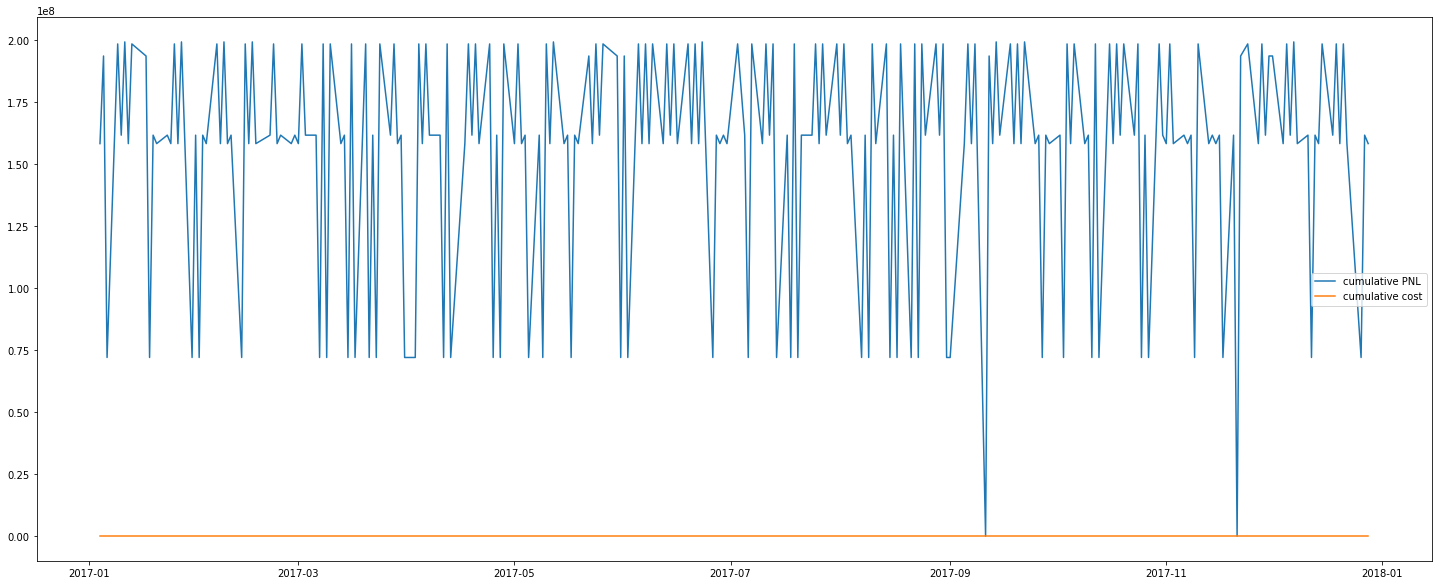

In [51]:
PNL_cs = PNL_matrix.sum(axis=0).cumsum()/kappa
cost_cs = cost_matrix.sum(axis=0).cumsum()/kappa
PNL_cs = PNL_cs.sort_index()
cost_cs = cost_cs.sort_index()
PNL_cs.index = pd.to_datetime(PNL_cs.index)
cost_cs.index = pd.to_datetime(cost_cs.index)
plt.figure(figsize=(25,10))
plt.plot(PNL_cs,label='cumulative PNL')
plt.plot(cost_cs,label='cumulative cost')
plt.legend()
plt.show()

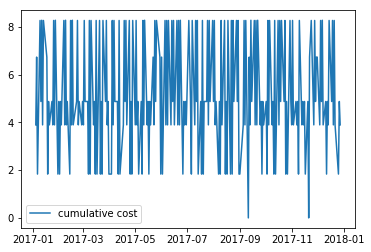

In [50]:
plt.plot(cost_cs,label='cumulative cost')
plt.legend()

3.a

In [17]:
tau=0.01
kappa=1.0
shrink=0.5
omega=0.015**2

# Define the Black-Litterman function
def computeBlackLitterman(FactorsData, Sigma, R, alpha, q, heq,kappa,omega):
    Cinv = 1./tau*np.linalg.inv(Sigma)    
    P = pd.DataFrame(alpha)
    Omegainv = np.array(1./omega).reshape(1,-1)
    q = np.array(q).reshape(1,-1)  
    Pi = kappa*(1+tau)*np.dot(Sigma,heq).reshape(-1,1)
    Hinv = np.linalg.inv(np.dot(np.dot(P,Omegainv),pd.DataFrame(P).T)+Cinv)    
    hopt = 1./kappa*np.dot(np.matmul(np.linalg.inv(Hinv+Sigma),Hinv),np.dot(np.dot(P,Omegainv),q)+np.dot(Cinv,Pi))
    return hopt.T[0]

def getMeanVarOptimal(xi, kappa,Sigma,alpha,omega,V,q):
    Sigmainv = np.linalg.inv(Sigma)
    Vinv = np.linalg.inv(V)
    Omegainv = np.array(1/omega).reshape(1,-1)
    q = np.array(q).reshape(1, -1)
    mu = np.dot(np.linalg.inv(Vinv+Omegainv+np.dot(alpha,np.dot(Sigmainv,alpha))),(np.dot(Vinv,alpha)+np.dot(Omegainv,q)).T)
    Pi = np.array(alpha)*mu.T 
    hstar = 1./kappa*np.dot(Sigmainv,Pi.T)
    hstar = hstar.reshape(-1)
    return hstar

3.b

In [18]:
bl = pd.Series([])
bm = pd.Series([])
bst = pd.Series([])

for date in dates:
    #filename = filenames[100]
    df = data2017[date]
    X = df1[style_factors + alpha_factors]
    alpha = X["td"]+X["tir"]
    Fi = F.loc[date, :, :]
    D = np.diag(sigma2_hat[X.index])
    Sigma = pd.DataFrame(np.dot(np.dot(X,Fi),X.T)+D, index = X.index, columns = X.index) 
    heq = df.loc[X.index,'USDCAP']
    V = np.diag(np.ones(len(Sigma.index)))   
    if len(Sigma.dropna())>0:
        Sigma = Sigma.fillna(0)
        R = df.loc[X.index,"R"]
        q=R*alpha.sum()
        q = q.fillna(0)
        #print(q)
        hopt = computeBlackLitterman(X, Sigma, R, alpha, q, heq,kappa,omega)
        hstar = getMeanVarOptimal(X,kappa,Sigma,alpha,omega,V,q)
        bl[date] = (hopt * R).sum()/(sum(hopt))
        bm[date] = (heq * R).sum()/(sum(heq))
        bst[date] = (hstar * R).sum()/(sum(hstar))

In [96]:
bl = bl*500# Black litterman
bm = bm*500# benchmark Portfolio
bst = bst*500# Markoviz

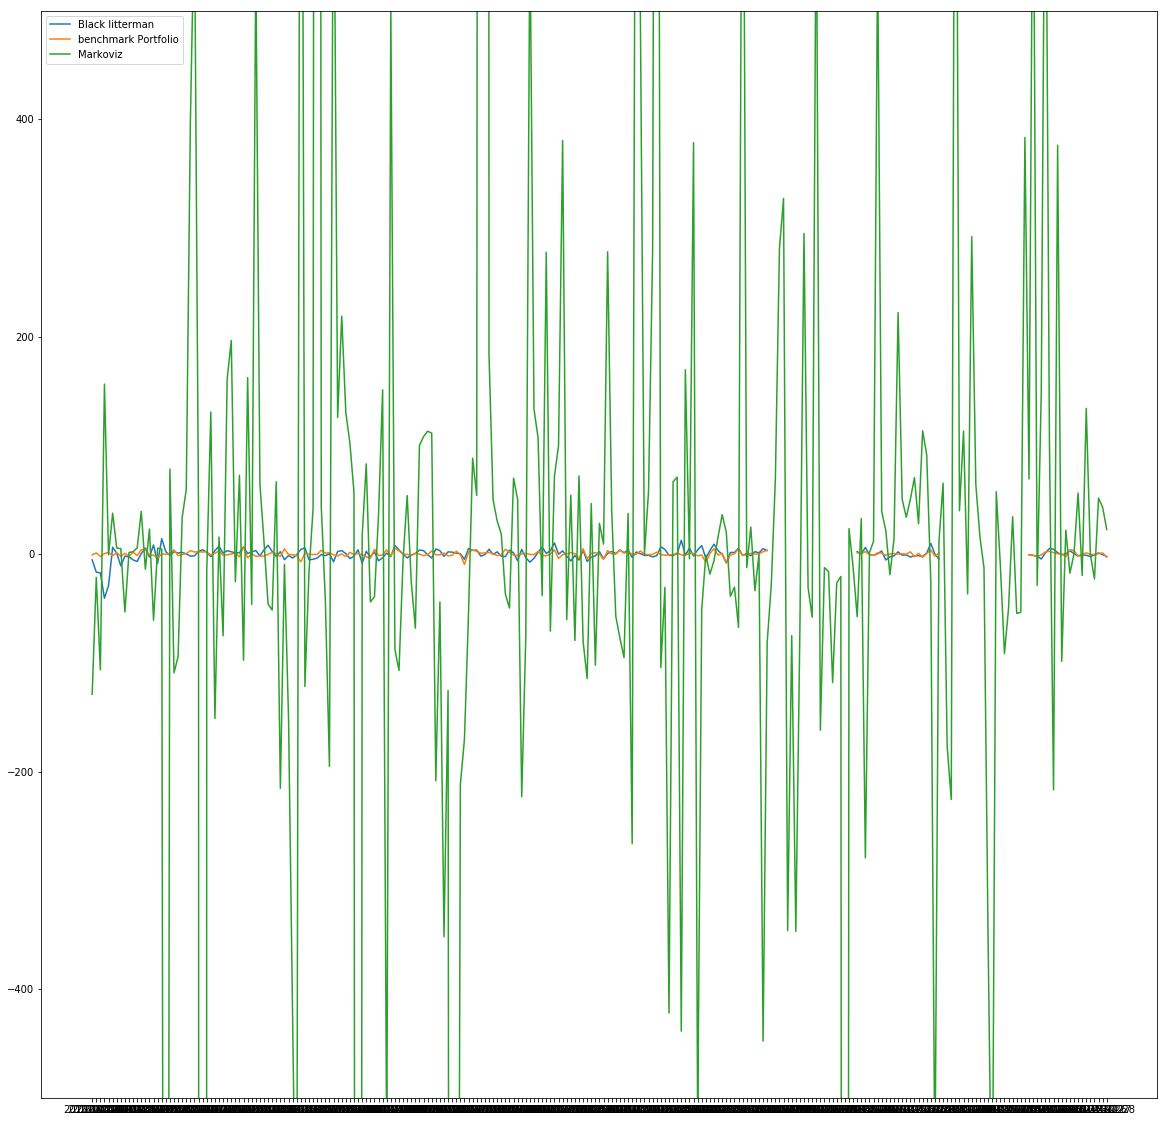

In [100]:
plt.figure(figsize=(20,20))
bl = bl.sort_index()
bm = bm.sort_index()
bst = bst.sort_index()
plt.ylim(-500, 500)
plt.plot(bl.index,bl,label='Black litterman')
plt.plot(bl.index,bm,label="benchmark Portfolio")
plt.plot(bl.index,bst,label="Markoviz")
plt.legend()
plt.show()

Problem4, used MixedLM package

In [101]:
LME_Fmatrix = pd.DataFrame() 
LME_Hmatrix =  pd.DataFrame() 
LME_PNLmatrix =  pd.DataFrame() 

for date in dates:
    df = data2017[date]
    X = df[style_factors + alpha_factors]
    Xt = X.as_matrix()
    Xt = Xt.astype(float) 
    #print("Xt: ",Xt.shape)
    rt = df["R"].values
    rt = rt.astype(float)
    groups =np.kron(np.arange(len(rt)),1)
    model = MixedLM(rt,Xt, groups)
    lmeresult = model.fit(full_output = True)
    beta =lmeresult.fe_params
    alphabeta = lmeresult.fe_params[[4,5]]
    LME_Fmatrix[date] = beta
    corr = lmeresult.normalized_cov_params[:,:-1][:-1]        
    fbeta = f_OLS_matrix.loc[date,alpha_factors]
    alpha = np.dot(X[alpha_factors].as_matrix().astype(float), alphabeta)
    D = np.diag(sigma2_hat[X.index])
    Sigma = pd.DataFrame(np.dot(np.dot(X,corr),X.T)+D, index = X.index, columns = X.index)
    if len(Sigma.dropna())>0:
        Sigma = Sigma.fillna(0)
        R = df.loc[X.index,"R"]
        hk = pd.Series(np.dot(np.linalg.inv(Sigma),alpha),index = X.index,name = date)
        LME_Hmatrix = pd.concat([LME_Hmatrix,hk],axis = 1)
        LME_PNLmatrix = pd.concat([LME_PNLmatrix, pd.Series(hk*R,name = date)],axis = 1)

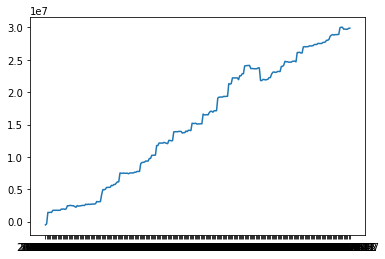

In [109]:
LME_PNL = LME_PNLmatrix.sum(axis=0).cumsum()/kappa
plt.plot(LME_PNL)

Problem 5

In [24]:
#Initial Parameters
l = np.log(2)/5
sigma = 0.1
pe = 50
N = 100000
kappa = 1e-4
gamma = 0.999
alpha = 0.001
delta = 0
tPNL = [0]

Generate Date

In [37]:
eps = np.random.normal(0,1,N)
xt = np.zeros(N)
for i in range(1,N):
    xt[i] = (1-l)*xt[i-1] + sigma*eps[i]
pt = np.array(np.exp(np.array(xt))*pe)

Action Space A = LotSize · {−K, −K + 1, . . . , K}

In [38]:
K = 5
Lotsize = 100.0
fA = np.array(range(-K, K+1))*Lotsize

Possible values for the holding

In [39]:
M = 10
H = np.array(range(-M, M+1))*Lotsize

Space fo possible prices

In [40]:
TickSize = 0.1
fP = np.array(range(1,1001))*TickSize 

Function of cost

In [41]:
def SpreadCost(delta, TickSize):
    return TickSize*np.abs(delta)

def ImpactCost(delta, TickSize, Lotsize):
    return delta**2*TickSize/Lotsize
    
def Cost(delta, TickSize, Lotsize):
    return SpreadCost(delta,TickSize) + ImpactCost(delta,TickSize, Lotsize)

Function of Rewards

In [42]:
def Reward(dvt, kappa):
    Rt = dvt - 0.5*kappa*(dvt**2)
    return Rt

Functions of Pnl and Sharpe Ratio

In [43]:
def sharpe_ratio(R):
    return (252*np.mean(R))/(np.sqrt(252)*np.var(R))
  
Nt = [0]
def PNL(pt, Nt, TickSize, Lotsize, i):
    cost =  Cost((Nt[i]-Nt[i-1]), TickSize, Lotsize)
    return  -(Nt[i]*(pt[i+1]-pt[i]) - cost)

Initial Q table

In [44]:
Q = np.array([[0]*len(pt)*len(H)]*(2*K+1))

Q learning algorithms

In [45]:
for i in range(1,N-1):
    env = np.array(list(set(fA).intersection(set(H-Nt[-1]))))
    Paction = (env/Lotsize + K).astype(int)
    pi = int(pt[i+1]/TickSize-1)
    Lpi = int(pt[i]/TickSize-1)
    delta1 = delta
    maxq = Q[Paction, pi*len(H):pi*(len(H)+1)].max()
    Pdelta = (np.where(Q[Paction, pi*len(H):pi*(len(H)+1)] == maxq)[0])
    delta = env[Pdelta[np.random.randint(len(Pdelta))]]
    Nt.append(Nt[-1] + delta)
    dvt = PNL(pt, Nt, TickSize, Lotsize, i)
    rt = Reward(dvt, kappa)
    Q[int(delta1/Lotsize + K),Lpi*len(H)+int(Nt[-2]/Lotsize+M)] = (1-alpha)*Q[int(delta1/Lotsize + K),Lpi*len(H)+int(Nt[-2]/Lotsize+M)] + alpha*(rt+gamma*maxq)
    tPNL.append(dvt)

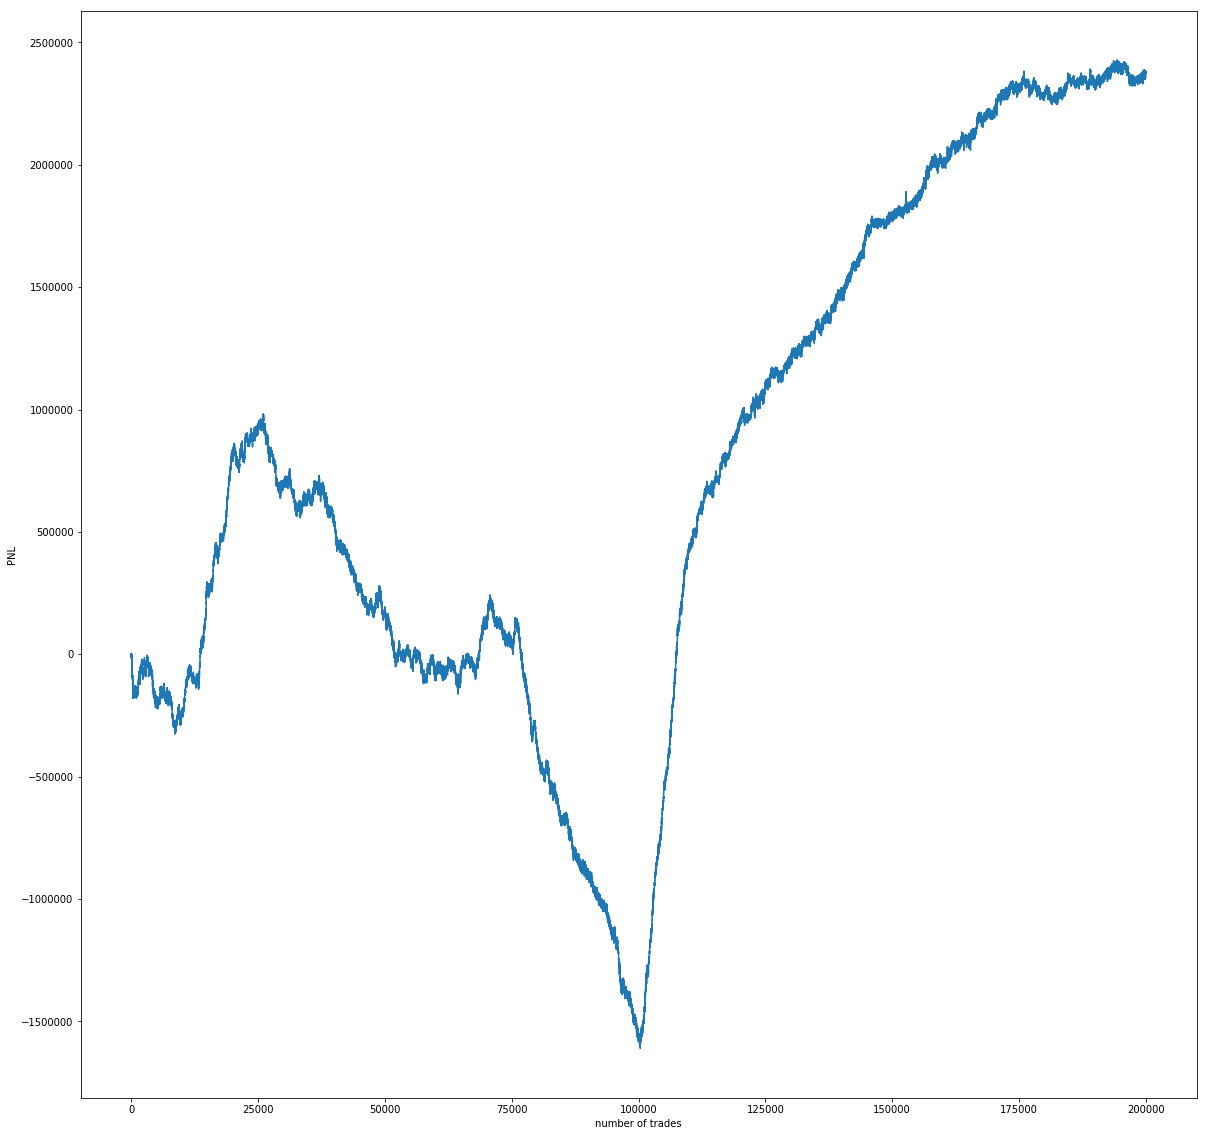

In [46]:
plt.figure(figsize=(20,20))
plt.xlabel('number of trades')
plt.ylabel('PNL')
plt.plot(pd.Series(tPNL).cumsum())